In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston

## IMPORTAR DATOS, ORDENARLOS Y LIMPIARLOS
Después de recolectar los datos desde la API de AEMET __(se explica en la memoria)__, vamos a importar el documento ya seleccionado sólo con los valores de las estaciones de la CCAA de Andalucía.

Lo más importante es preparar los datos para el analisis y contestar a la hipótesis del proyecto.

In [21]:
df = pd.read_csv("data/AEMET/aemet_and.csv")
df.head()

df.drop("Unnamed: 0", axis = 1, inplace=True)

#Crear formato fecha y sacar la columna mes
df["fecha"] = pd.to_datetime(df["fecha"])
df["mes"] = df["fecha"].dt.month

#Reordenar las columnas
ordenado = df.reindex(columns=["fecha", "mes", "nombre", "provincia", "altitud", "tmed", "tmin", "tmax", "prec", "velmedia", "racha"]).sort_values(["nombre", "fecha"])

#Sacar las capitales de provincia
capitales = ordenado[(ordenado["nombre"]=="ALMERÍA AEROPUERTO")|
                (ordenado["nombre"]=="CÁDIZ")|
                (ordenado["nombre"]=="CÓRDOBA AEROPUERTO")|
                (ordenado["nombre"]=="GRANADA AEROPUERTO")|
                (ordenado["nombre"]=="HUELVA, RONDA ESTE")|
                (ordenado["nombre"]=="JAÉN")|
                (ordenado["nombre"]=="MÁLAGA, CENTRO METEOROLÓGICO")|
                (ordenado["nombre"]=="SEVILLA AEROPUERTO")]
capitales.head()

#Sustituir comas por puntos y los valores "Ip" por Nones
nocomas = capitales.replace(",",".", regex=True)
noip = nocomas.replace("Ip", None, regex=True)


#Convertir las columnas de str en float
noip["tmed"]=noip["tmed"].astype(float)
noip["tmax"]=noip["tmax"].astype(float)
noip["tmin"]=noip["tmin"].astype(float)
noip["prec"]=noip["prec"].astype(float)
noip["velmedia"]=noip["velmedia"].astype(float)
noip["racha"]=noip["racha"].astype(float)
noip["provincia"]=noip["provincia"].astype(str)

#Borrar NaN
temp= noip.dropna(how="any")
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 33 to 14235
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      2876 non-null   datetime64[ns]
 1   mes        2876 non-null   int64         
 2   nombre     2876 non-null   object        
 3   provincia  2876 non-null   object        
 4   altitud    2876 non-null   int64         
 5   tmed       2876 non-null   float64       
 6   tmin       2876 non-null   float64       
 7   tmax       2876 non-null   float64       
 8   prec       2876 non-null   float64       
 9   velmedia   2876 non-null   float64       
 10  racha      2876 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 269.6+ KB


c:\Users\jorge\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\missing.py:94: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [22]:
temp.describe()

,mes,altitud,tmed,tmin,tmax,prec,velmedia,racha
count,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,6.542768,171.723227,19.513491,13.831398,25.195549,1.139917,3.257441,9.873818
std,3.460271,233.721463,6.442374,6.245873,7.516109,4.657006,1.745538,3.449696
min,1.000000,2.000000,4.200000,-5.300000,7.600000,0.000000,0.000000,2.800000
25%,4.000000,18.000000,14.100000,9.400000,18.900000,0.000000,2.200000,7.500000
50%,7.000000,34.000000,19.400000,13.900000,24.200000,0.000000,3.100000,9.200000
75%,10.000000,560.000000,24.500000,18.800000,30.900000,0.000000,3.900000,11.700000
max,12.000000,580.000000,36.300000,28.200000,44.800000,79.200000,14.200000,26.700000


## GRÁFICOS
Estos gráficos pueden ayudarnos a realizar el análisis posteriormente.

In [23]:
#plotly bubble charts

data = [
    {
        'y': temp['tmed'],
        'x': temp['mes'],
        'mode': 'markers',
        'marker': {
            'color': temp["tmin"],
            'size': temp["tmax"],
            'showscale': True
        },
        'text': temp['provincia']
    }
]

iplot(data)

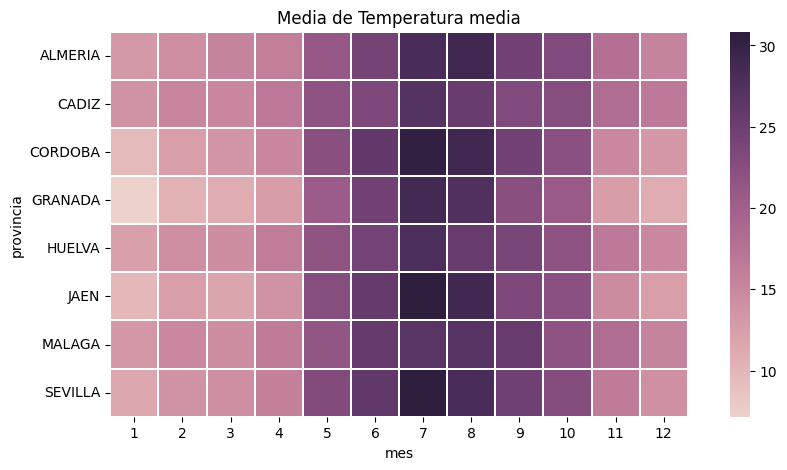

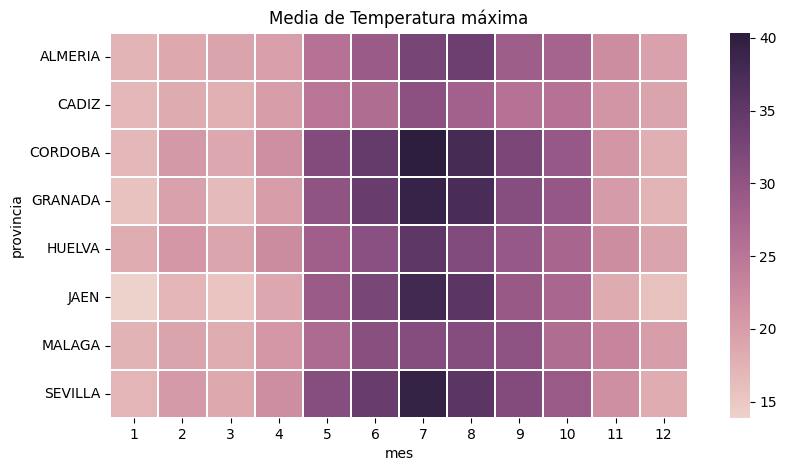

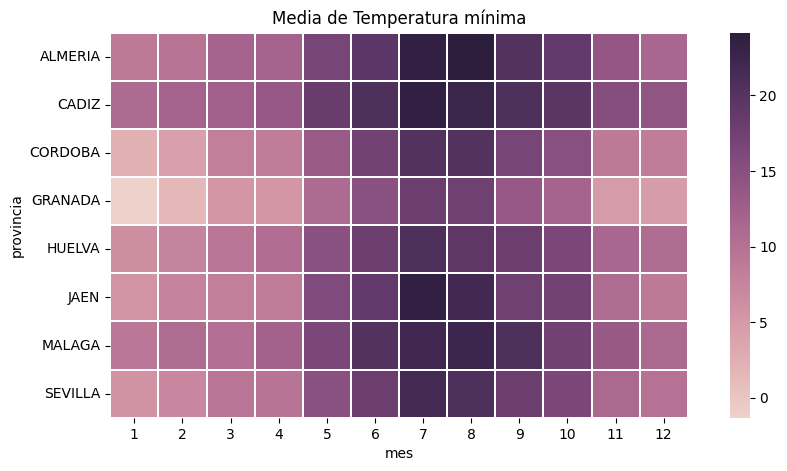

In [24]:
#Mapas de calor

data = temp.groupby(["provincia", "mes"]).mean()["tmed"].unstack()

plt.figure(figsize=(11,5))
sns.heatmap(data,
            square=True,
            linewidths=.3,
            cmap=sns.cubehelix_palette(as_cmap=True)).set(title='Media de Temperatura media');

data = temp.groupby(["provincia", "mes"]).mean()["tmax"].unstack()

plt.figure(figsize=(11,5))
sns.heatmap(data,
            square=True,
            linewidths=.3,
            cmap=sns.cubehelix_palette(as_cmap=True)).set(title='Media de Temperatura máxima');


data = temp.groupby(["provincia", "mes"]).mean()["tmin"].unstack()

plt.figure(figsize=(11,5))
sns.heatmap(data,
            square=True,
            linewidths=.3,
            cmap=sns.cubehelix_palette(as_cmap=True)).set(title='Media de Temperatura mínima');

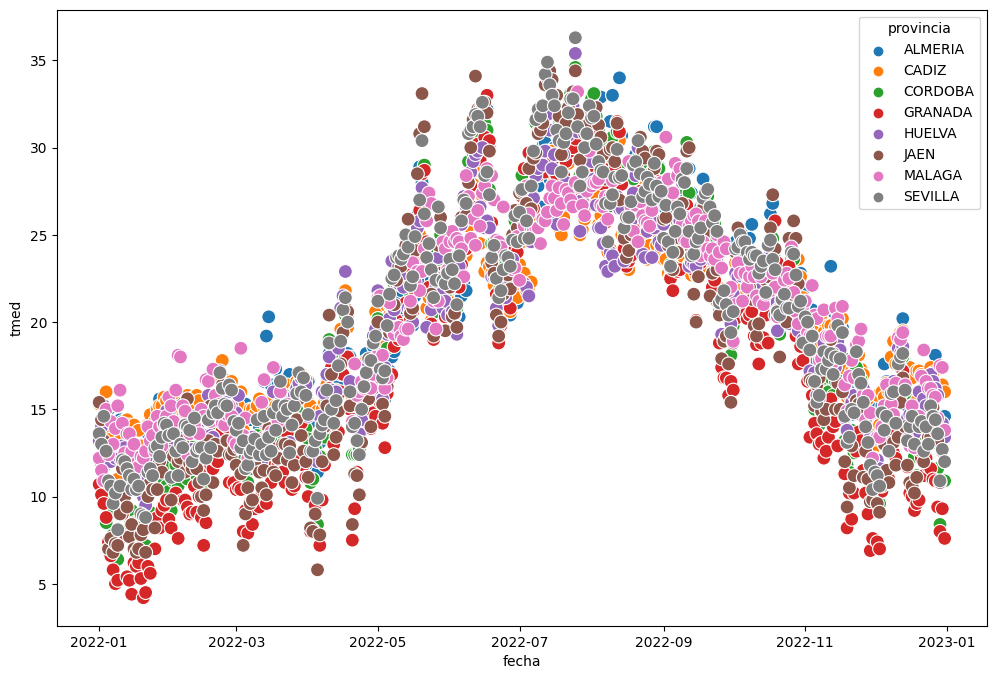

In [25]:
#Distribución de temperaturas por provincia en el tiempo
dt_graf = temp.groupby(["provincia", "fecha"]).mean()["tmed"].unstack()
plt.figure(figsize=(12,8))
sns.scatterplot(x = temp["fecha"],
y = temp["tmed"],
s = 100,
hue = temp["provincia"]);

In [26]:
altitudes = pd.DataFrame(temp["altitud"].unique(), temp["provincia"].unique())
altitudes

,0
ALMERIA,21
CADIZ,2
CORDOBA,90
GRANADA,560
HUELVA,18
JAEN,580
MALAGA,54
SEVILLA,34


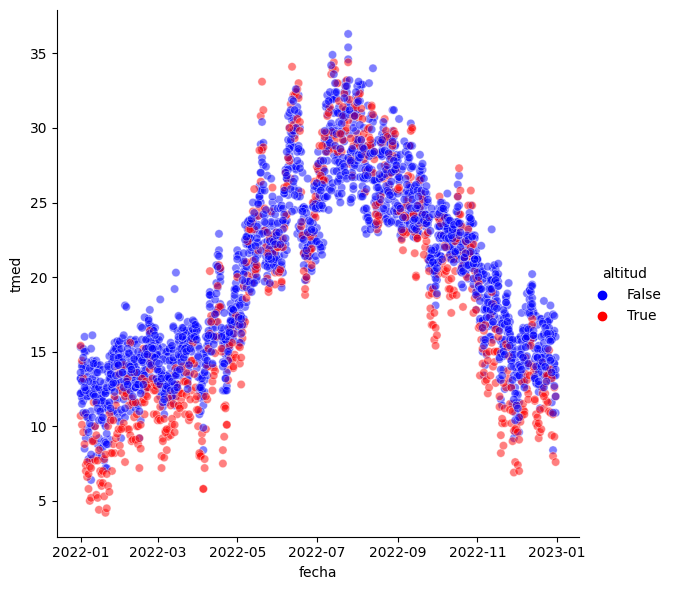

In [27]:
sns.relplot(data=temp,
            x= temp["fecha"],
            y= temp["tmed"],
            hue = temp["altitud"] > 500,
            sizes=(4, 300),
            alpha=.5, palette=["b", "r"],
            height=6);

C:\Users\jorge\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jorge\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jorge\AppData\Roaming\Python\Python37\site-packag

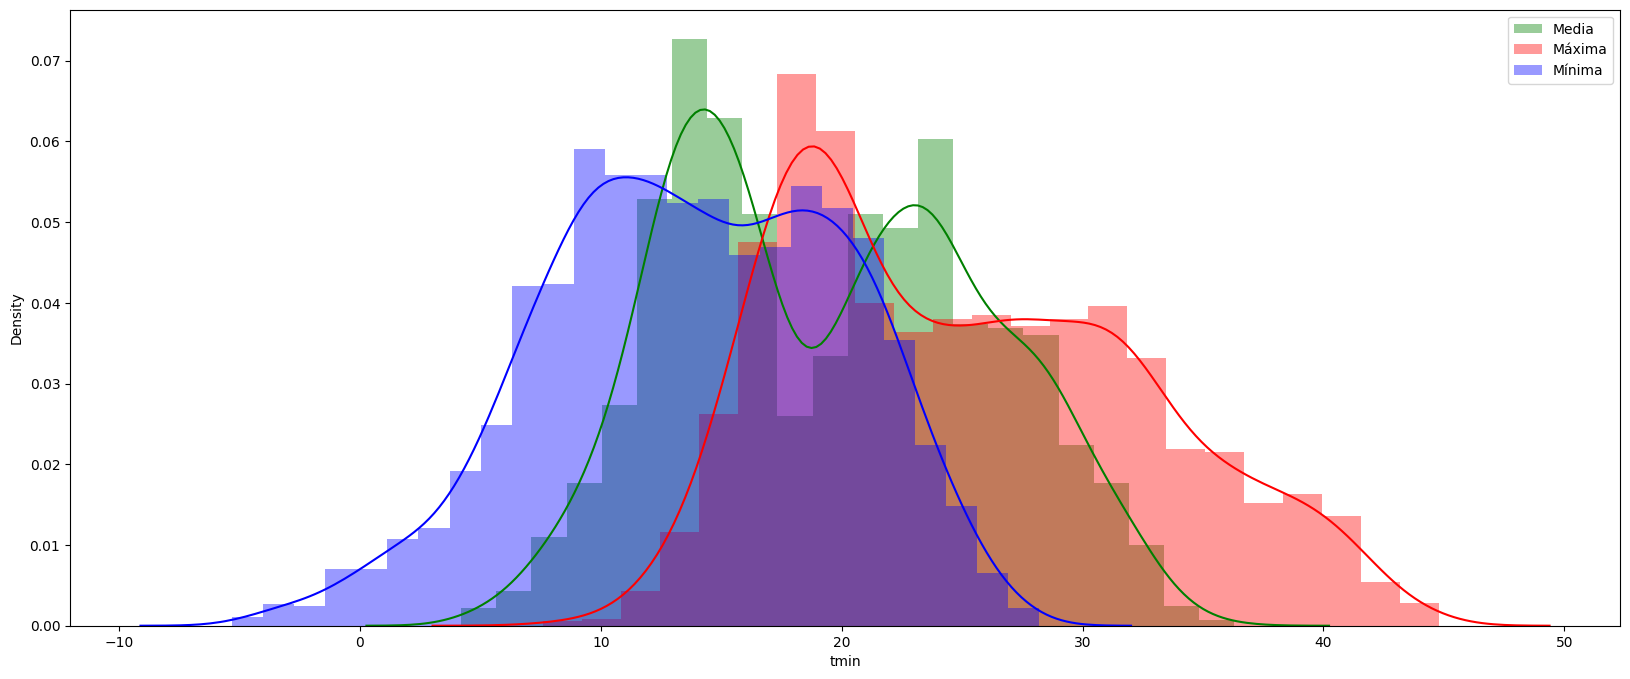

In [28]:
#Curva de temperturas

plt.figure(figsize=(20,8))
sns.distplot(temp["tmed"] , color="green", label="Media")
sns.distplot(temp["tmax"]  , color="red", label="Máxima")
sns.distplot(temp["tmin"]  , color="blue", label="Mínima")
plt.legend();

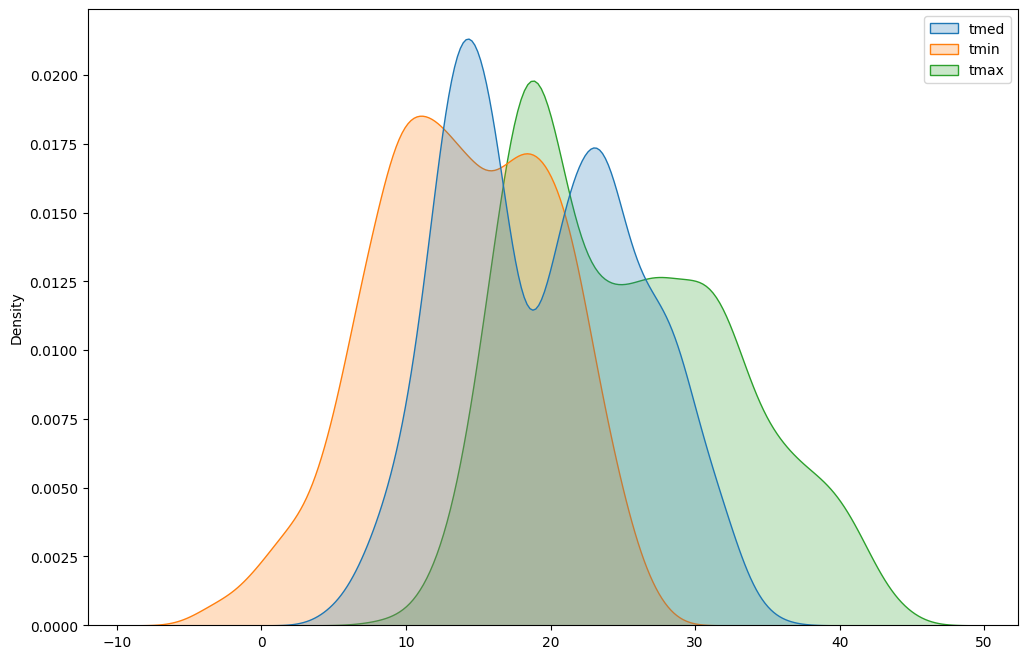

In [29]:
plt.figure(figsize=(12,8))
sns.kdeplot(data = temp[temp.columns.values[5:8]], fill = True);

<Figure size 1600x800 with 0 Axes>

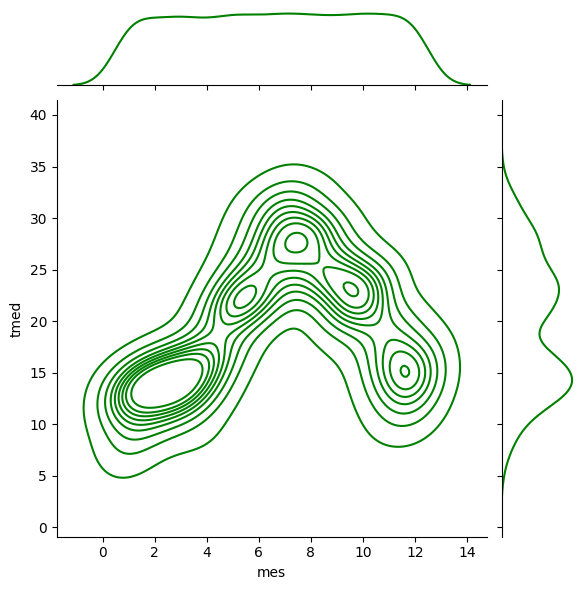

In [30]:
plt.figure(figsize=(16,8))
sns.jointplot(x= temp["mes"],
              y= temp["tmed"],
              kind = "kde",
              color = "green");

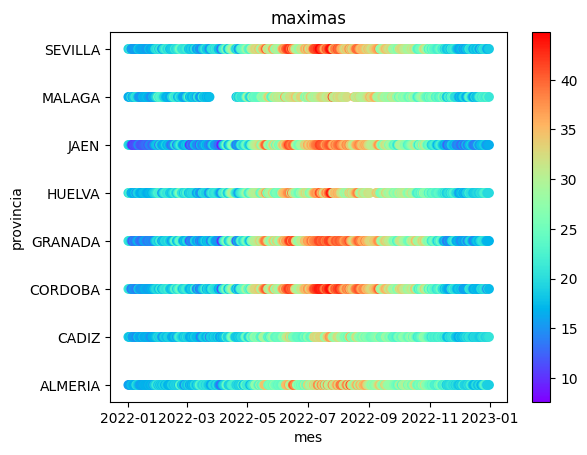

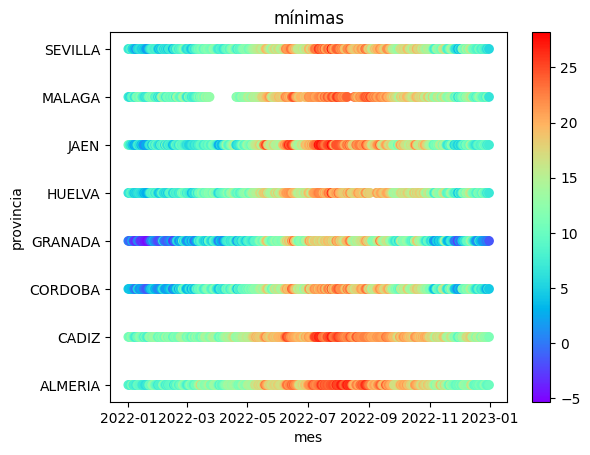

In [31]:
#Evolución de las temperaturas máximas y mínimas por provincias en el tiempo

fig = plt.figure()
scat = plt.scatter(temp["fecha"], 
                   temp["provincia"], 
                   c=temp["tmax"], 
                   cmap=plt.cm.rainbow)

fig.colorbar(scat) 
plt.xlabel("mes")
plt.ylabel("provincia")
plt.title('maximas')
plt.show()

fig = plt.figure()
scat = plt.scatter(temp["fecha"], 
                   temp["provincia"], 
                   c=temp["tmin"], 
                   cmap=plt.cm.rainbow)
 
# colorbar to explain the color scheme
fig.colorbar(scat)
 
plt.xlabel("mes")
plt.ylabel("provincia")
plt.title('mínimas')
plt.show()

In [160]:
#Sacar datos de minimas y máximas por provincias

provin = ["ALMERIA", "CADIZ", "CORDOBA", "GRANADA", "HUELVA", "JAEN", "MALAGA", "SEVILLA"]
maximo = temp.groupby(temp["provincia"]).max()
maximo = [42, 37.3, 44.2, 42.1, 43.9, 41.7, 41.5, 44.8]
minimo = temp.groupby(temp["provincia"]).min()
minimo = [6.1, 7.4, -1.6, -5.3, 2.7, 1.1, 5.4, 1.1]

max_min = pd.DataFrame(columns = ("Provincias", "tmax", "tmin", "amplitud"))
max_min["Provincias"] = provin
max_min["tmax"] = maximo
max_min["tmin"] = minimo
max_min["amplitud"] = max_min["tmax"]-max_min["tmin"]

max_min.sort_values("amplitud", ascending=False)




,Provincias,tmax,tmin,amplitud
3,GRANADA,42.1,-5.3,47.4
2,CORDOBA,44.2,-1.6,45.8
7,SEVILLA,44.8,1.1,43.7
4,HUELVA,43.9,2.7,41.2
5,JAEN,41.7,1.1,40.6
6,MALAGA,41.5,5.4,36.1
0,ALMERIA,42.0,6.1,35.9
1,CADIZ,37.3,7.4,29.9


c:\Users\jorge\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:3544: UserWarning:

50.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\jorge\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:3544: UserWarning:

50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\jorge\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:3544: UserWarning:

43.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\jorge\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:3544: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



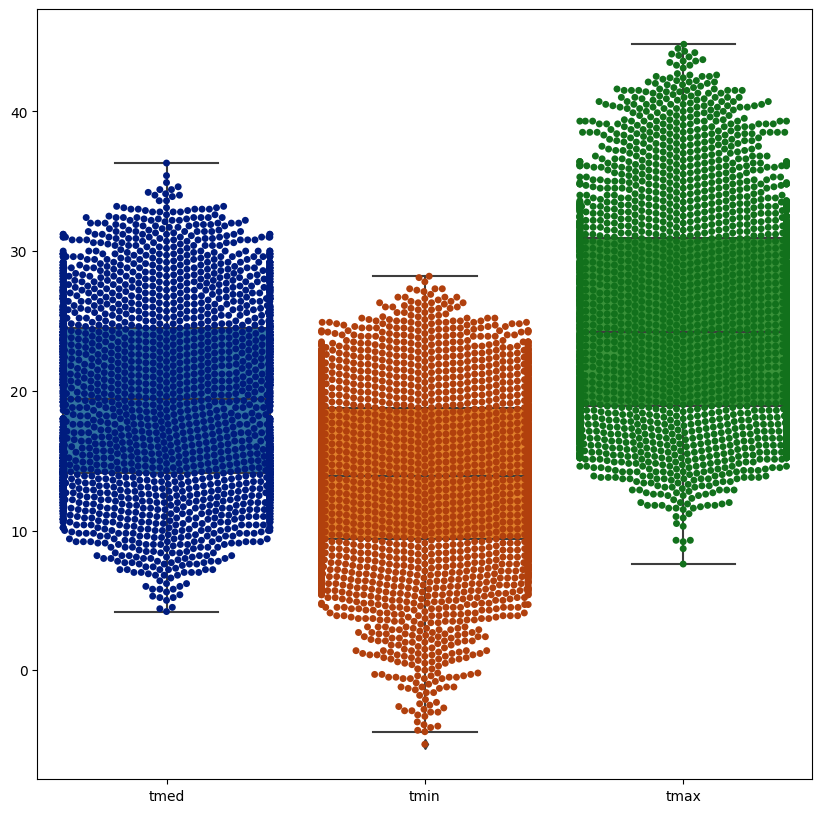

In [32]:
#Distribución de las temperaturas

plt.figure(figsize=(10,10))
sns.boxplot(data=temp[temp.columns.values[5:8]])
sns.swarmplot(data=temp[temp.columns.values[5:8]], palette="dark");

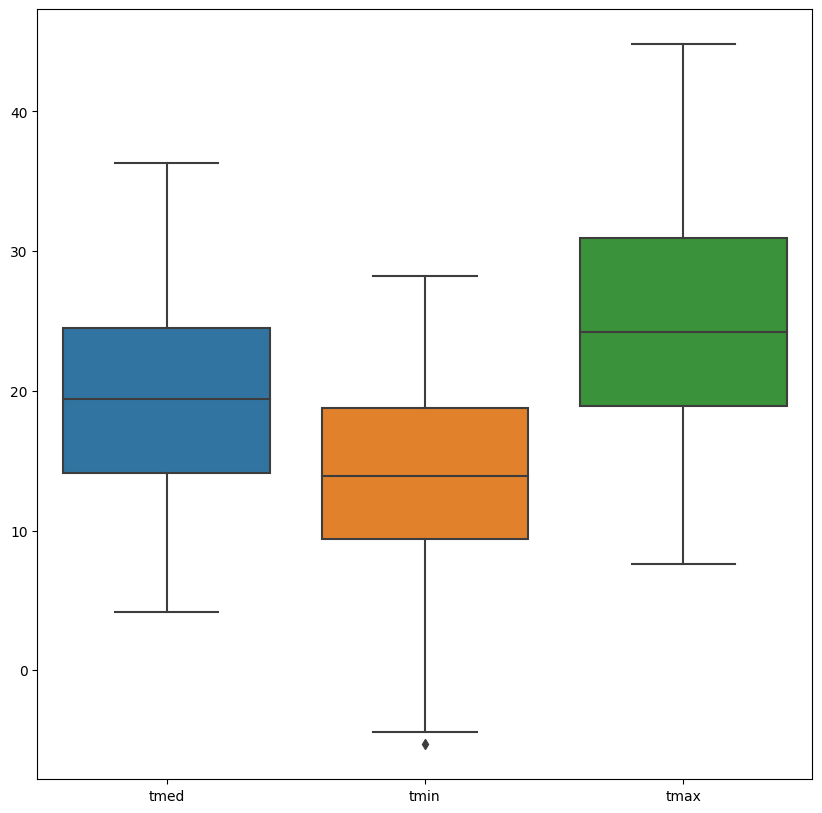

In [33]:
plt.figure(figsize=(10,10))
sns.boxplot(data=temp[temp.columns.values[5:8]]);

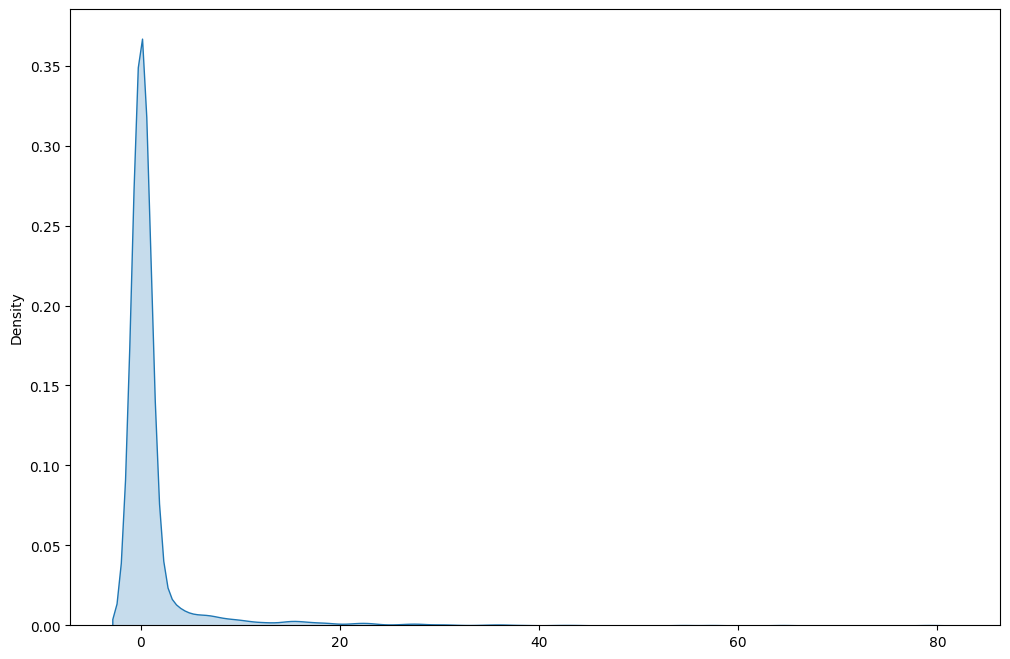

In [34]:
plt.figure(figsize=(12,8))
sns.kdeplot(data = temp["prec"].values, fill=True);

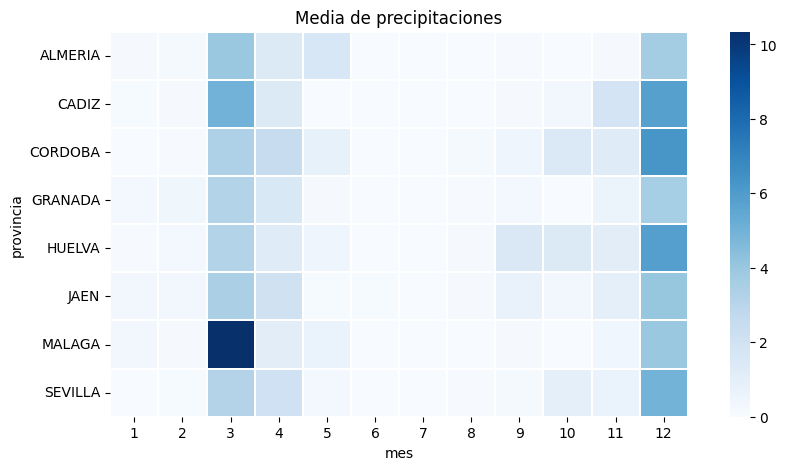

In [35]:
#Mapa de calor de las precipitaciones

data = temp.groupby(["provincia", "mes"]).mean()["prec"].unstack()

plt.figure(figsize=(11,5))
sns.heatmap(data,
            square=True,
            linewidths=.3,
            cmap="Blues").set(title='Media de precipitaciones');

<Figure size 3000x3000 with 0 Axes>

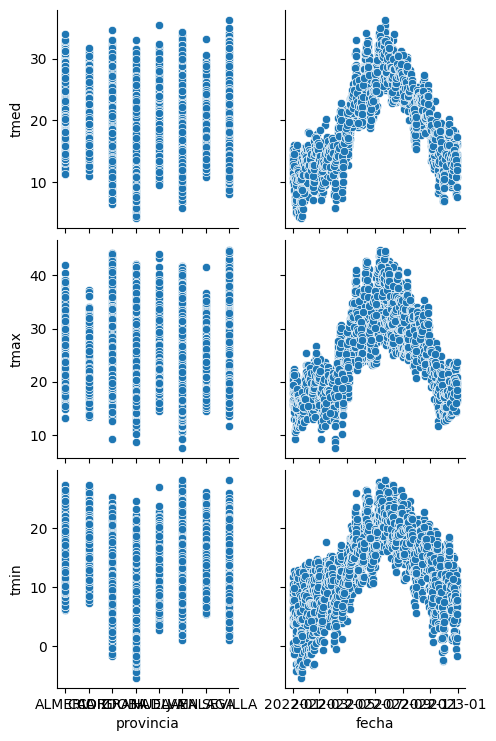

In [36]:
plt.figure(figsize=(30,30))
sns.pairplot(
    temp,
    x_vars=["provincia", "fecha"],
    y_vars=["tmed", "tmax", "tmin"])